In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [15]:
directory = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

classes = [i for i in os.listdir(directory) if "." not in i]
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [16]:
label = []
path = []
images= []

for dir_name, _, filenames in os.walk(directory):
    for filename in filenames:
        if dir_name.split()[-1]!="GT":
            if os.path.splitext(filename)[-1]==".png":
                label.append(os.path.split(dir_name)[-1])
                img_path=os.path.join(dir_name,filename)
                path.append(img_path)
                
                #Normalization
                with Image.open(img_path) as img:
                    img = img.resize((225, 225)) 
                    img_array = np.asarray(img).astype('float32') / 255  # Normalization step
                    images.append(img_array)
                
data= pd.DataFrame(columns=["path","label"])
data["path"]=path
data["label"]=label

In [11]:
data

path            label
0     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
...                                                 ...              ...
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream

[9000 rows x 2 columns]

In [12]:
data.label.value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

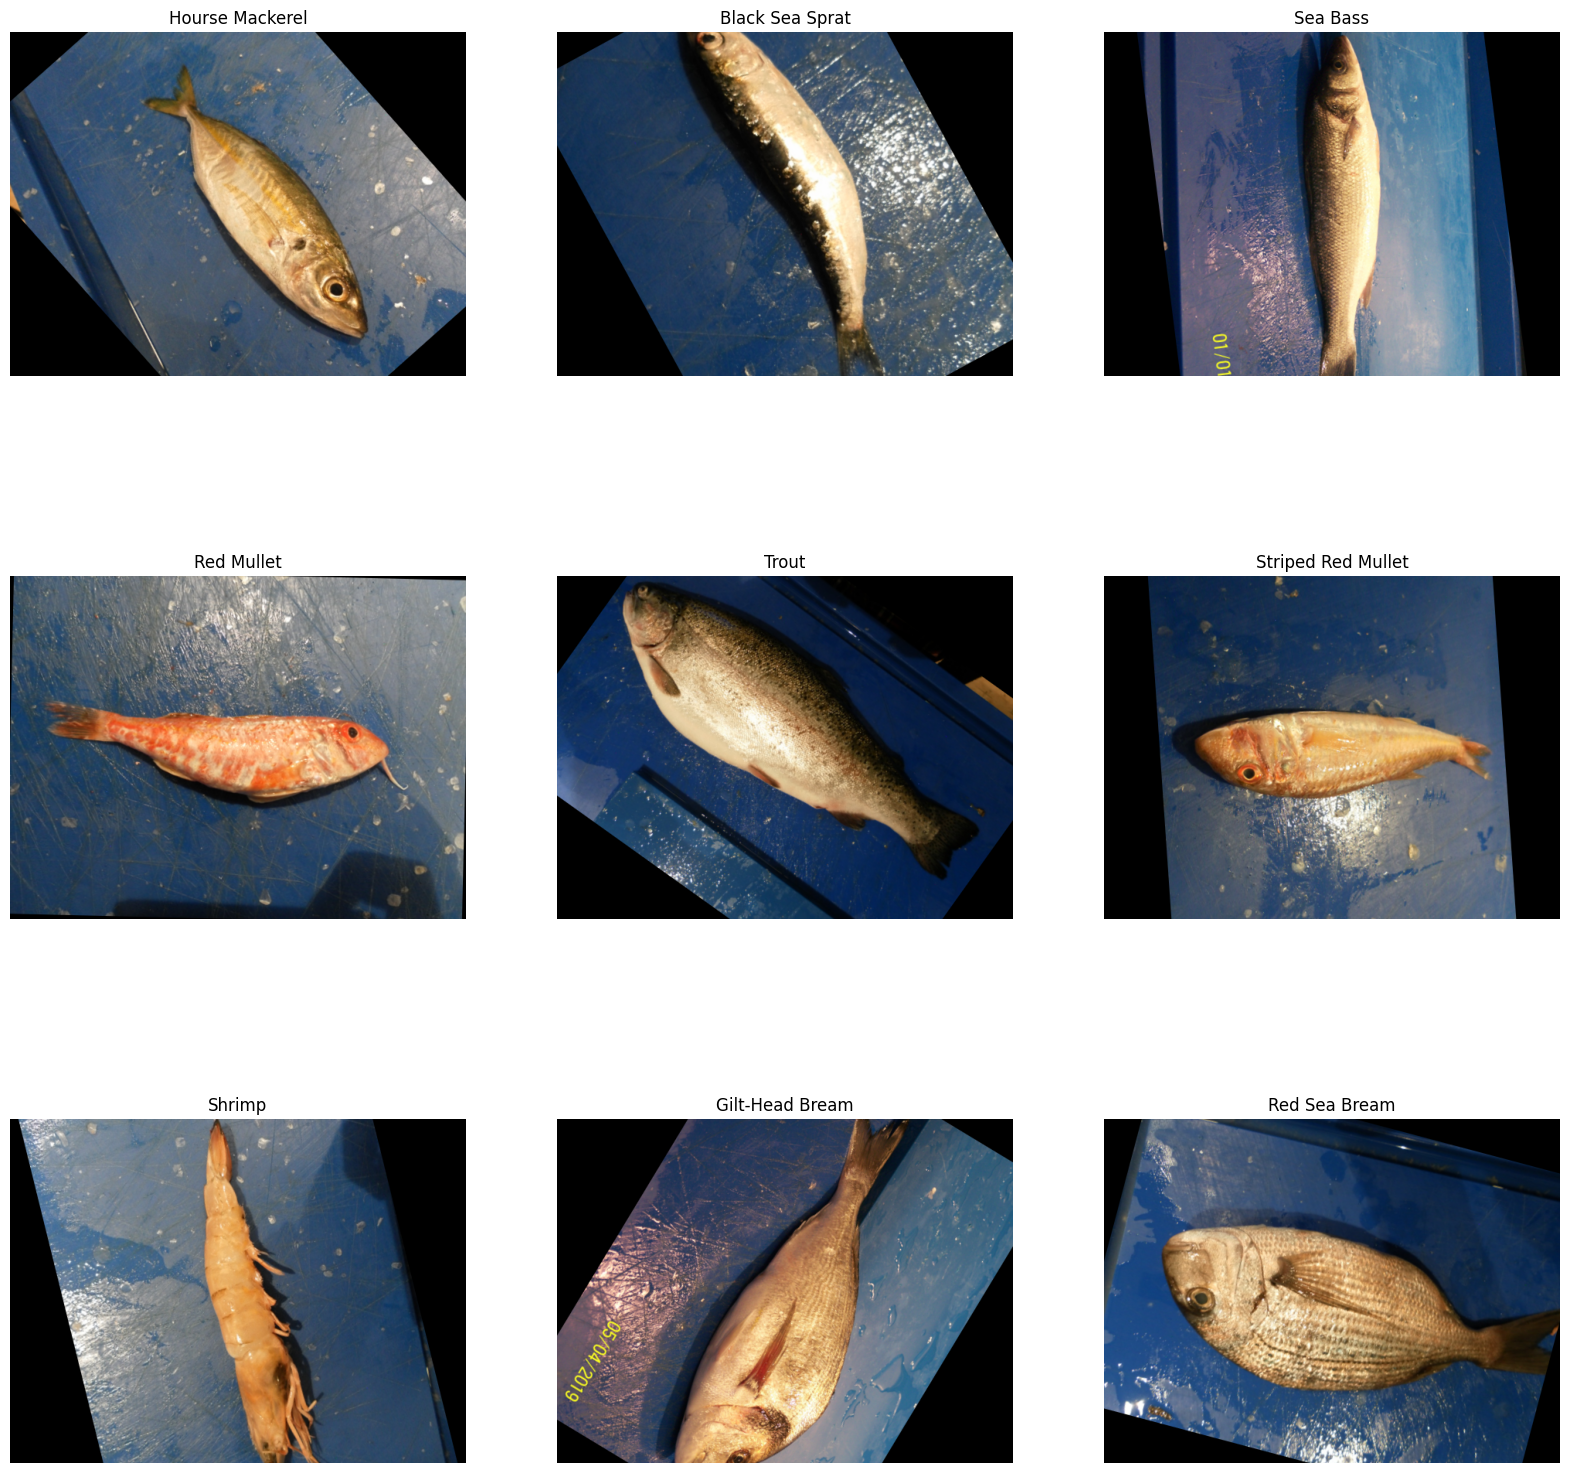

In [13]:
cn = 0
plt.figure(figsize=(20,20))
for unique_label in data["label"].unique():
    plt.subplot(3, 3, cn+1)
    plt.imshow(plt.imread(data[data["label"]==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis("off")
    cn+=1

# Library keras

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model



from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score, f1_score,precision_score, confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix

In [19]:
#Spliting train and test data
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)


print("Training data size: ", len(train_data))
print("Test data size: ", len(test_data))

Training data size:  7200
Test data size:  1800


In [22]:
#data agumentaiton
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
#One-hot encoding and Train set 
image_size = (224, 224)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,            
    x_col='path',              
    y_col='label',             
    target_size=image_size,    
    batch_size=32,             
    class_mode='categorical',  
    subset='training'          
)

#Validaiton
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'        # Validation verileri
)

#Test set

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False   )     # no shuffle in test set

Found 6120 validated image filenames belonging to 9 classes.
Found 1080 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [24]:
model = Sequential([
    Flatten(input_shape=(224, 224, 3)),  # Görseli tek boyutlu hale getir
    Dense(512, activation='relu'),       # İlk dense katman
    Dense(256, activation='relu'),       # İkinci dense katman
    Dense(128, activation='relu'),       # Üçüncü dense katman
    Dense(len(train_data['label'].unique()), activation='softmax')  # Çıkış katmanı
])

In [54]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
#model summary
model.summary()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    restore_best_weights=True,  
    verbose=1            
)

In [55]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 82s 405ms/step - accuracy: 0.2438 - loss: 20.0566 - val_accuracy: 0.5194 - val_loss: 1.6022
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 79s 401ms/step - accuracy: 0.5815 - loss: 1.2727 - val_accuracy: 0.7519 - val_loss: 0.7215
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 80s 403ms/step - accuracy: 0.7280 - loss: 0.8162 - val_accuracy: 0.7593 - val_loss: 0.7459
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 79s 399ms/step - accuracy: 0.7910 - loss: 0.6058 - val_accuracy: 0.7000 - val_loss: 0.8661
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 78s 392ms/step - accuracy: 0.8359 - loss: 0.4803 - val_accuracy: 0.8722 - val_loss: 0.4130
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 79s 399ms/step - accuracy: 0.8655 - loss: 0.3903 - val_accuracy: 0.8120 - val_loss: 0.5665
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 79s 398ms/step - accuracy: 0.8919 - loss: 0.3065 - val_accuracy: 0.8778 - val_loss: 0.3522
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 78s 394ms/step - accuracy: 0.8855 - loss: 

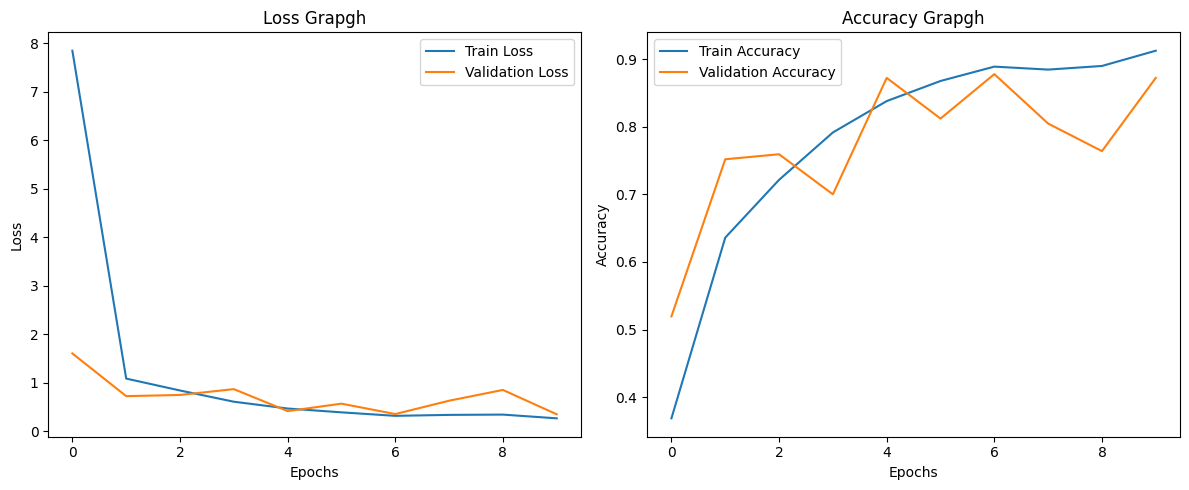

In [56]:
#Results figure 
plt.figure(figsize=(12, 5))

# Loss grap
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grapgh')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grapgh')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step
                    precision    recall  f1-score   support

   Hourse Mackerel       0.95      0.79      0.86       200
   Black Sea Sprat       0.81      0.89      0.85       200
          Sea Bass       0.93      0.90      0.91       200
        Red Mullet       0.95      0.95      0.95       200
             Trout       0.81      1.00      0.89       200
Striped Red Mullet       0.88      0.84      0.86       200
            Shrimp       0.97      0.89      0.93       200
   Gilt-Head Bream       0.96      0.77      0.85       200
     Red Sea Bream       0.76      0.90      0.82       200

          accuracy                           0.88      1800
         macro avg       0.89      0.88      0.88      1800
      weighted avg       0.89      0.88      0.88      1800



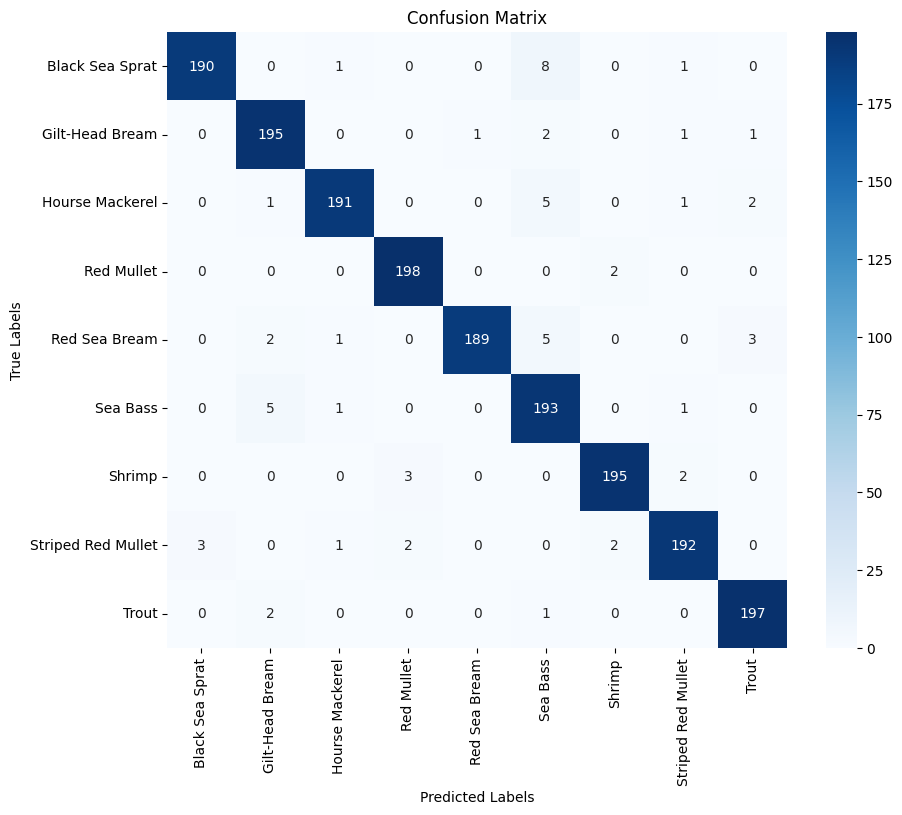

In [57]:
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)

print(classification_report(test_generator.classes, test_pred_classes, target_names=classes))
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Hiperparametre optimizasyonu

In [25]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

In [26]:
model = Sequential()

model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))

model.add(Dense(len(train_data['label'].unique()), activation='softmax'))  #output layer


opt= Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
#model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,204,489 (294.51 MB)

 Trainable params: 77,204,489 (294.51 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,          
    restore_best_weights=True,  
    verbose=1            
)

In [29]:
history = model.fit(train_generator, 
                    epochs=100, 
                    batch_size = 32,
                    validation_data=test_generator,
                    callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1729584316.125624     455 service.cc:145] XLA service 0x7a1218009e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729584316.125704     455 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/192 ━━━━━━━━━━━━━━━━━━━━ 20:23 6s/step - accuracy: 0.0625 - loss: 2.2587

I0000 00:00:1729584318.741887     455 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


192/192 ━━━━━━━━━━━━━━━━━━━━ 87s 421ms/step - accuracy: 0.2625 - loss: 2.0043 - val_accuracy: 0.5367 - val_loss: 1.3294
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 81s 410ms/step - accuracy: 0.5312 - loss: 1.3461 - val_accuracy: 0.6594 - val_loss: 1.0421
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 81s 410ms/step - accuracy: 0.6076 - loss: 1.1257 - val_accuracy: 0.7239 - val_loss: 0.8972
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 81s 410ms/step - accuracy: 0.6781 - loss: 0.9583 - val_accuracy: 0.7333 - val_loss: 0.8299
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 82s 415ms/step - accuracy: 0.7081 - loss: 0.8660 - val_accuracy: 0.7767 - val_loss: 0.7397
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 81s 410ms/step - accuracy: 0.7537 - loss: 0.7630 - val_accuracy: 0.8000 - val_loss: 0.6579
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 81s 412ms/step - accuracy: 0.7660 - loss: 0.7282 - val_accuracy: 0.8233 - val_loss: 0.5814
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 82s 414ms/step - accuracy: 0.7989 - loss: 0.646

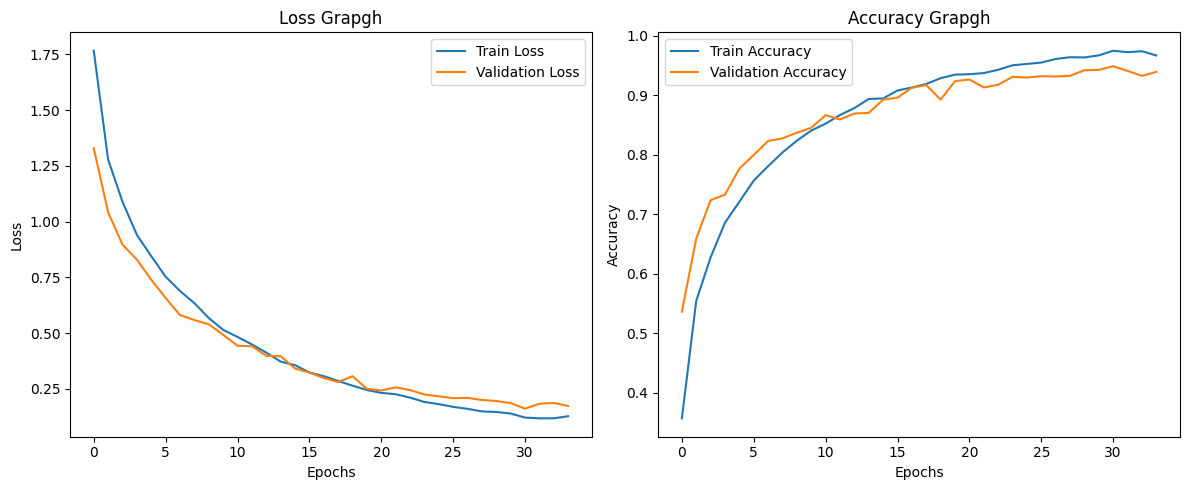

In [30]:
#Results figure 
plt.figure(figsize=(12, 5))

# Loss grap
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grapgh')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grapgh')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 317ms/step
                    precision    recall  f1-score   support

   Hourse Mackerel       0.95      0.95      0.95       200
   Black Sea Sprat       0.94      0.97      0.95       200
          Sea Bass       0.94      0.97      0.96       200
        Red Mullet       0.95      0.98      0.97       200
             Trout       0.94      0.97      0.96       200
Striped Red Mullet       0.93      0.89      0.91       200
            Shrimp       0.97      0.94      0.95       200
   Gilt-Head Bream       0.95      0.95      0.95       200
     Red Sea Bream       0.96      0.91      0.94       200

          accuracy                           0.95      1800
         macro avg       0.95      0.95      0.95      1800
      weighted avg       0.95      0.95      0.95      1800



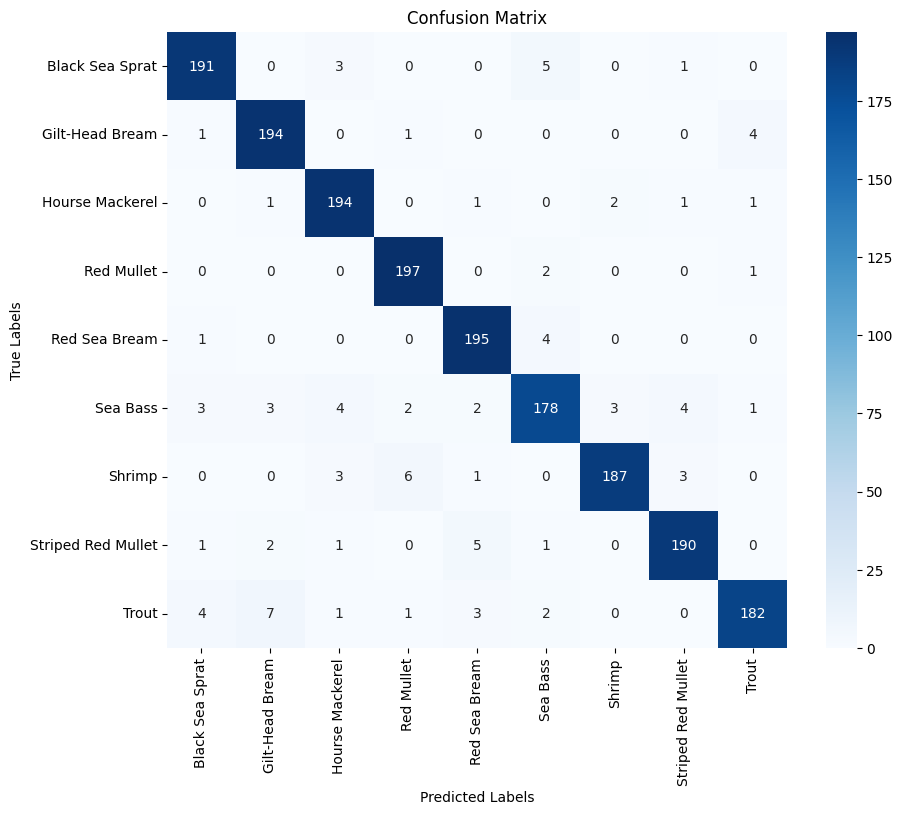

In [31]:
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
true_labels=test_generator.classes
print(classification_report(test_generator.classes, test_pred_classes, target_names=classes))
cm = confusion_matrix(true_labels, test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# SEEING THE RESULTS EXAMPLE

57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 313ms/step


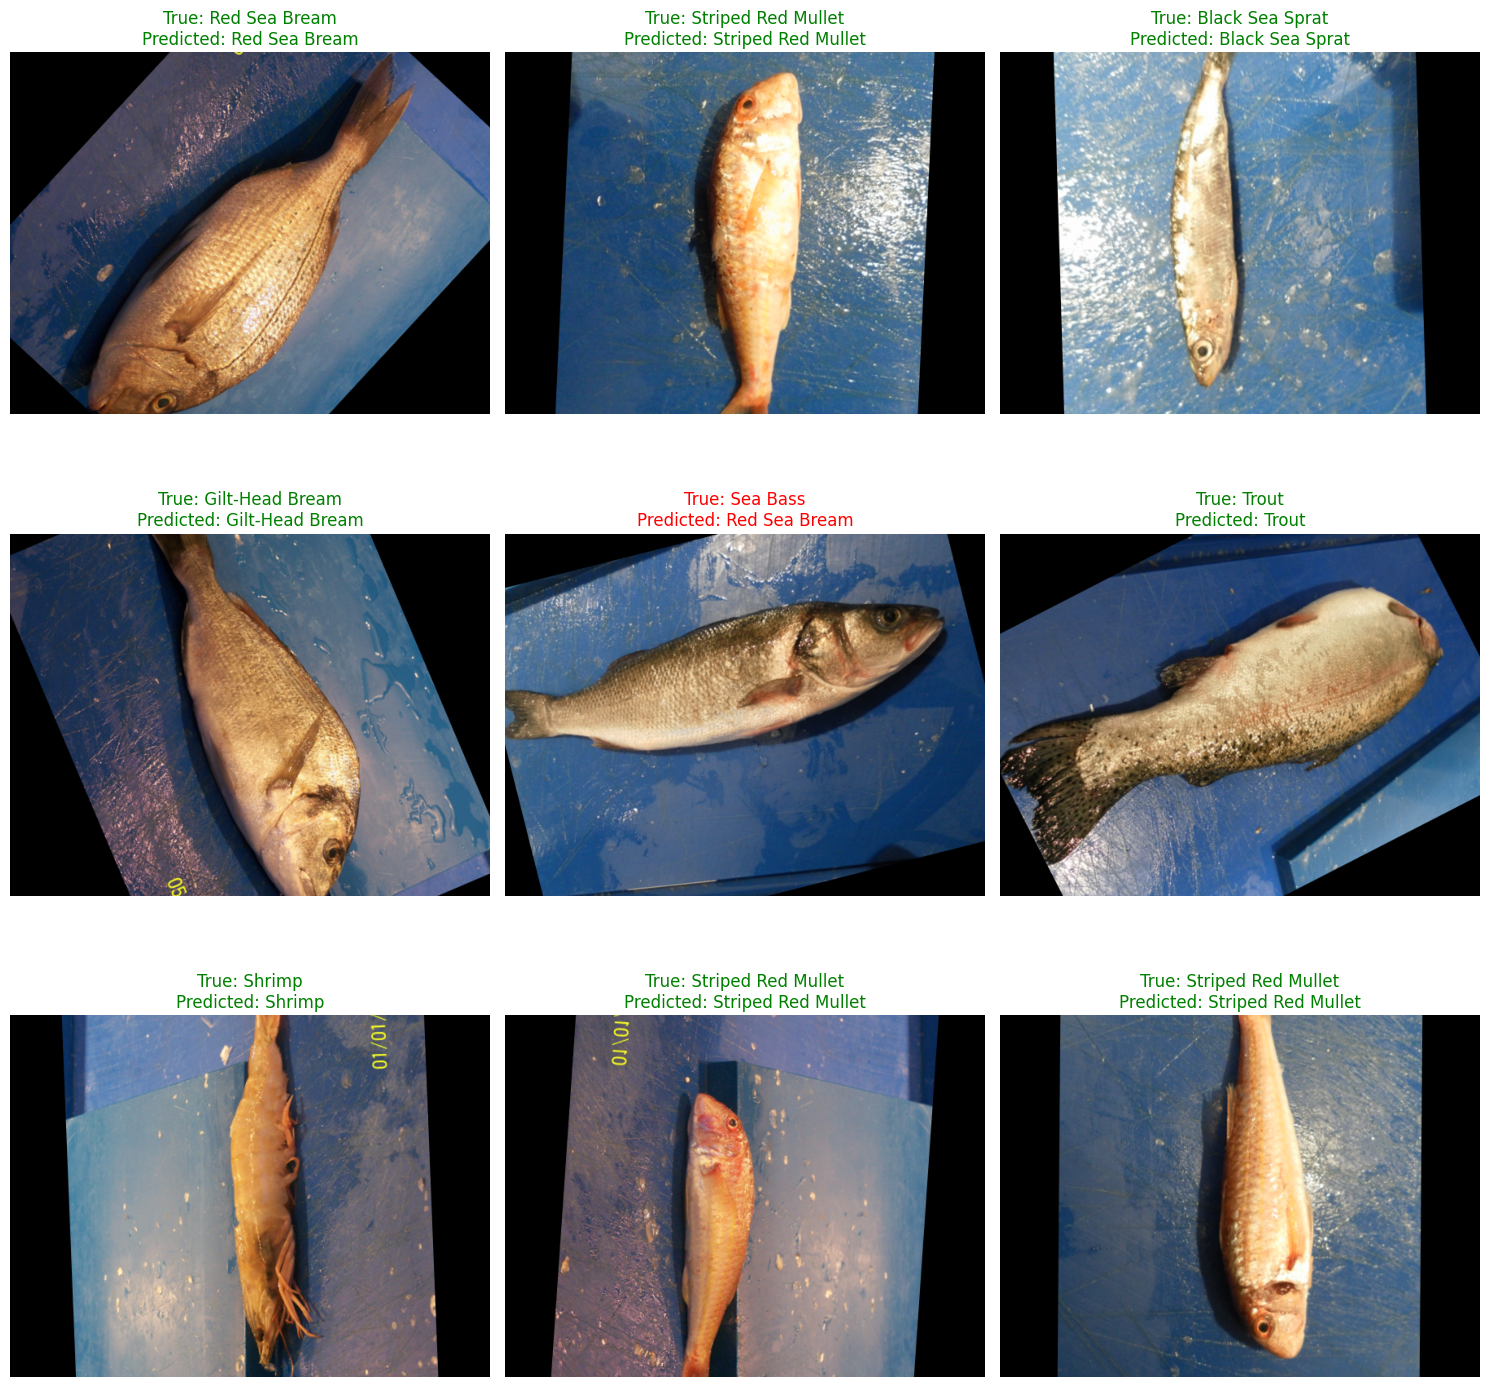

In [32]:
#Predictions of test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

#Actual date of test
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

#Random examples to see predictions and actual results
num_samples = 9 
random_indices = np.random.choice(len(true_labels), num_samples, replace=False)
test_images_paths = test_generator.filepaths 

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    img_path = test_images_paths[idx]
    img = plt.imread(img_path)
    
    true_label = class_names[true_labels[idx]]
    predicted_label = class_names[predicted_classes[idx]]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color='green' if true_label == predicted_label else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

**2nd time**

57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 313ms/step


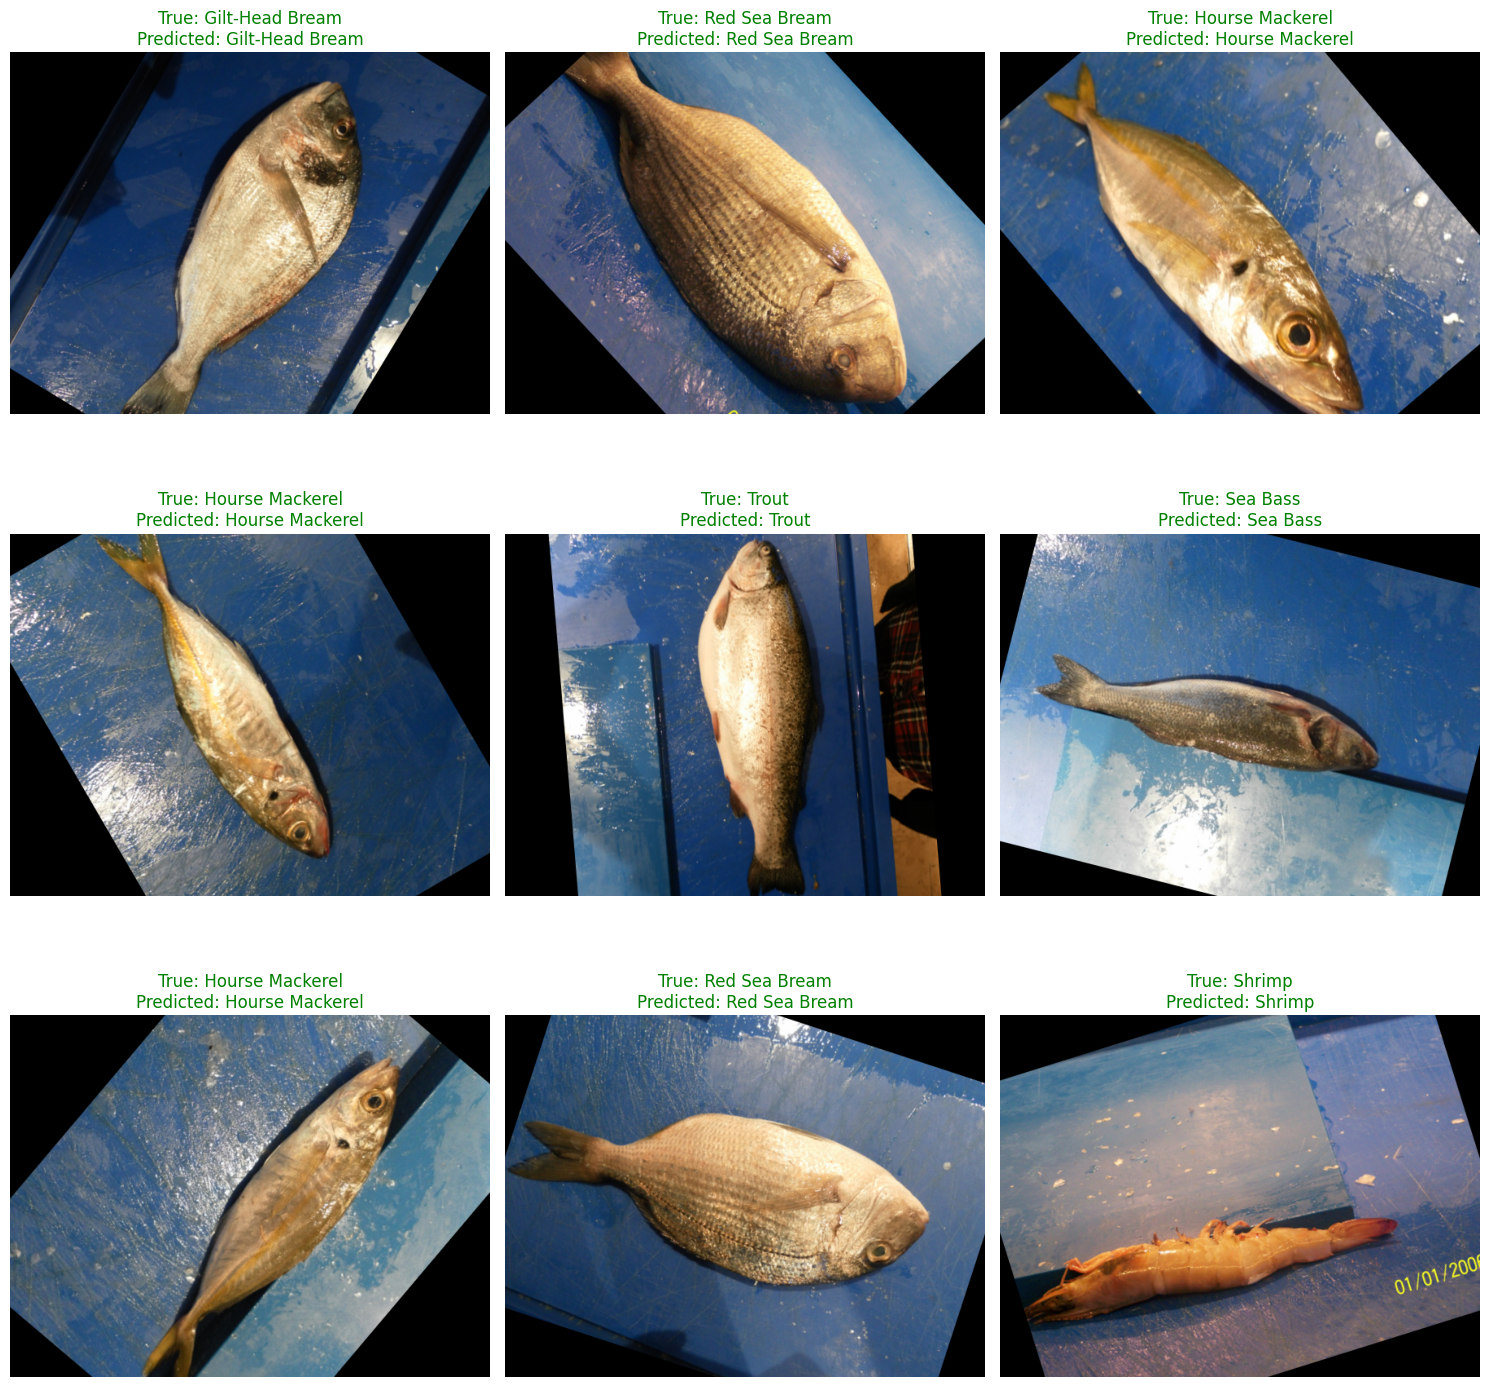

In [33]:
#Predictions of test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

#Actual date of test
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

#Random examples to see predictions and actual results
num_samples = 9 
random_indices = np.random.choice(len(true_labels), num_samples, replace=False)
test_images_paths = test_generator.filepaths 

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    img_path = test_images_paths[idx]
    img = plt.imread(img_path)
    
    true_label = class_names[true_labels[idx]]
    predicted_label = class_names[predicted_classes[idx]]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color='green' if true_label == predicted_label else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()